# 프로젝트 소개

CNN 기법을 활용해 운전 중 발생할 수 있는 다양한 행동을 인식하고 분류하는 시스템을 구현

# 주요기능
● TPU를 활용하여 실행

● 10가지 카테고리에 해당하는 클래스 이름을 폴더에서 읽어와 레이블로 사용하기 위한 준비

● 랜덤회전 , 랜덤 수평플립, 랜덤 대비 조정 3가지 데이터 증강 적용

● TensorFlow 데이터셋을 생성하고, **커스텀 CNN 아키텍처**를 설계하여 입력 데이터에 대해 동작 인식 모델을 학습하도록 설계

● Epoch 146번 훈련 결과 Train_accuracy 98%, Train_Loss 6% Valid_accuracy 99%, Valid_Loss 3%에 도달

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


구글코랩 TPU 설정  https://colab.research.google.com/notebooks/tpu.ipynb

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.15.0
Running on a TPU w/8 cores


10가지 카테고리에 해당하는 클래스 이름을 폴더에서 읽어와 레이블로 사용하기 위한 준비

In [ ]:
# 0: 'Safe Driving',
# 1: 'Left-Handed Phone Use While Driving',
# 2: 'Right-Handed Calling While Driving',
# 3: 'Right-Handed Phone Use While Driving',
# 4: 'Left-Handed Calling While Driving',
# 5: 'Navigation Use While Driving',
# 6: 'Drinking Coffee While Driving',
# 7: 'Reaching to the Back While Driving',
# 8: 'Grooming While Driving',
# 9: 'Talking to Passenger While Driving'

import os
driver_image_path = '/content/drive/MyDrive/driver_motion/imgs/train'
class_names = sorted(os.listdir(driver_image_path))
print(class_names)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


단일 이미지를 로드하여 불러오기와 이미지 크기를 확인

In [ ]:
import cv2
imageee = cv2.imread('/content/drive/MyDrive/driver_motion/imgs/train/c0/img_100026.jpg')
imageee.shape

(240, 320, 3)

OpenCV로 불러온 이미지의 파일 경로를 images 리스트에 넣어주고 인코딩한 레이블을 각 이미지에 할당(17471개의 이미지와 레이블)

In [ ]:
img_size = (200 , 200, 3)

images = []
labels = []

for class_name in class_names:
  images_files_folder_name = os.path.join(driver_image_path , class_name)
  if os.path.isdir(images_files_folder_name):
    for image_name in os.listdir(images_files_folder_name):
      if image_name.endswith('.jpg'):
        image_full_path = os.path.join(images_files_folder_name , image_name)
        #print(image_full_path)
        img = cv2.imread(image_full_path)
        img_cvt = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)

        images.append(img_cvt)

        label = class_names.index(class_name)
        labels.append(label)

print(f"Total images : {len(images)} , Total labels : {len(labels)}")

Total images : 17471 , Total labels : 17471


성능 최적화를 위해 이미지와 마스크 리스트를 넘파이 형태로 변환                                                                                                                                                            

TPU 사용 시, 파일 단위 데이터를 직접 처리하는 대신 넘파이 배열로 미리 준비하면 TensorFlow Dataset 생성 및 데이터 로드 속도가 크게 향상(수십 분 -> 초 단위)

In [ ]:
import numpy as np
images = np.asarray(images)
masks = np.asarray(masks)

images , labels 리스트를 X_train 과 X_val로 분할(Train에 80%, Validation에 20% 할당)

In [ ]:
from sklearn.model_selection import train_test_split
X_train , X_val , y_train , y_val = train_test_split(images , labels , test_size = 0.2)

랜덤회전 , 랜덤 수평플립, 랜덤 대비 조정 3가지 데이터 증강 적용

In [ ]:
import tensorflow as tf
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.05),             #랜덤 회전
    tf.keras.layers.RandomFlip(mode='horizontal'),           #랜덤 수평 플립
    tf.keras.layers.RandomContrast(factor=0.2),              #랜덤 대비 조정
])

차례대로 이미지 크기를 지정된 크기로 조정해주는 전처리 함수 , 이미지 증강 함수, 이미지와 레이블을 TensorFlow 데이터셋으로 변환하고, 전처리 및 증강을 적용하여 배치와 프리패칭을 설정하는 Tensorflow 데이터셋 생성 함수 정의

In [ ]:
#이미지 크기를 지정된 크기로 조정해주는 함수
def preprocessing_image(image , label):
  image = tf.image.resize(image , img_size[:2])
  return image , label

#이미지에 이미지 증강을 적용해주는 함수
def augment_image(image , label):
  image = data_augmentation(image)
  return image , label

#이미지와 레이블을 tensorflow dataset으로 변환하고, 전처리 및 증강을 적용하여 배치와 프리패칭을 설정하는 함수
def create_tensorflow_dataset(images ,labels , batch_size = 32 , buffer_size = 1000 , augment = False):
  dataset = tf.data.Dataset.from_tensor_slices((images , labels))
  dataset = dataset.map(preprocessing_image , num_parallel_calls = tf.data.AUTOTUNE)
  if augment:
    dataset = dataset.map(augment_image , num_parallel_calls = tf.data.AUTOTUNE)
  dataset = dataset.shuffle(buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
  return dataset

TPU 사용시 큰 배치사이즈를 사용해야 좋지만 64 , 128 , 256 사용시 성능이 안좋게 나와 32 배치사이즈로 설정

In [ ]:
global_batch_size = 32 * tpu_strategy.num_replicas_in_sync

앞서 정의한 TensorFlow Dataset 함수를 이용하여 Train_dataset 및 Val_dataset 데이터셋 생성(Train_dataset에만 데이터 증강 적용)

In [ ]:
train_dataset = create_tensorflow_dataset(X_train , y_train , batch_size = global_batch_size , buffer_size = len(X_train) , augment = True)
val_dataset = create_tensorflow_dataset(X_val , y_val , batch_size = global_batch_size , buffer_size = len(X_val) , augment = False)

다중 합성곱 층 , 배치 정규화 , MaxPooling2D , Dropout등의 레이어를 사용하여 커스텀 CNN 아키텍처 구축

Epoch 146번 훈련 결과 Train_accuracy 98%, Train_Loss 6% Valid_accuracy 99%, Valid_Loss 3%에 도달                                                                          
기본 adam 학습률을 사용 , EarlyStopping을 사용하고 patience = 20으로 설정

In [ ]:
with tpu_strategy.scope():
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape = img_size),
      tf.keras.layers.Rescaling(scale = 1. / 255),
      tf.keras.layers.Conv2D(64 , kernel_size = 3, padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Conv2D(64 , kernel_size = 3, padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(pool_size = 2),

      tf.keras.layers.Conv2D(128 , kernel_size = 2, padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Conv2D(128 , kernel_size = 2, padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(pool_size = 2),

      tf.keras.layers.Conv2D(256 , kernel_size = 2, padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Conv2D(256 , kernel_size = 2, padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(pool_size = 2),

      tf.keras.layers.Conv2D(512 , kernel_size = 2, padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.Conv2D(512 , kernel_size = 2, padding = 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Activation('relu'),
      tf.keras.layers.MaxPooling2D(pool_size = 2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256 , activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128 , activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64 , activation = 'relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(len(class_names) , activation = 'softmax')
  ])
  model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss' , patience = 20)
history = model.fit(train_dataset , epochs = 150 , validation_data = val_dataset , callbacks = [early_stopping_cb])

Epoch 1/150
55/55 [==============================] - 70s 1000ms/step - loss: 4.3665 - accuracy: 0.1085 - val_loss: 2.3500 - val_accuracy: 0.0864
Epoch 2/150
55/55 [==============================] - 15s 257ms/step - loss: 2.2504 - accuracy: 0.1496 - val_loss: 2.3020 - val_accuracy: 0.1064
Epoch 3/150
55/55 [==============================] - 15s 271ms/step - loss: 2.0153 - accuracy: 0.2504 - val_loss: 2.3115 - val_accuracy: 0.0867
Epoch 4/150
55/55 [==============================] - 14s 241ms/step - loss: 1.7087 - accuracy: 0.3860 - val_loss: 2.6775 - val_accuracy: 0.0867
Epoch 5/150
55/55 [==============================] - 15s 267ms/step - loss: 1.4908 - accuracy: 0.4660 - val_loss: 3.6461 - val_accuracy: 0.0835
Epoch 6/150
55/55 [==============================] - 15s 258ms/step - loss: 1.3145 - accuracy: 0.5407 - val_loss: 4.0428 - val_accuracy: 0.0830
Epoch 7/150
55/55 [==============================] - 15s 257ms/step - loss: 1.1960 - accuracy: 0.5844 - val_loss: 2.2086 - val_accuracy

Matplotlib를 사용하여 Accuracy 및 Loss 시각화

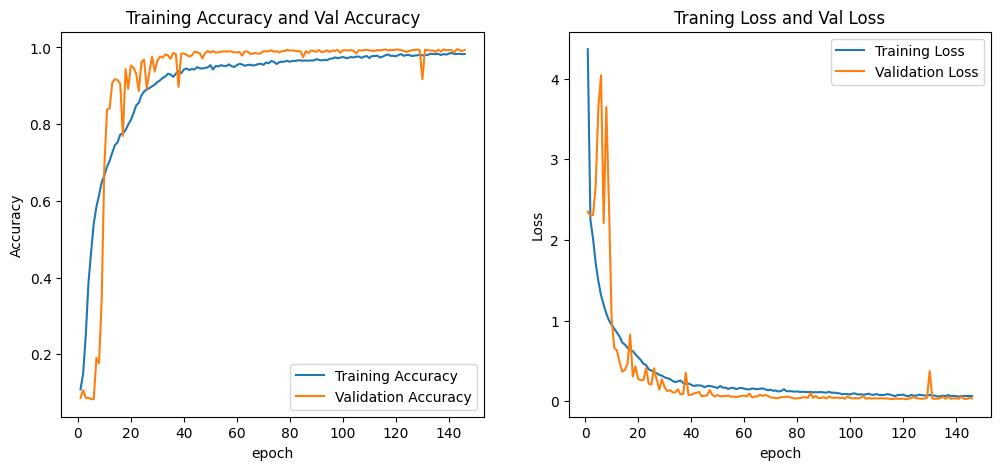

In [ ]:
history = history.history
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
epoch = range(1 , len(loss) + 1)

import matplotlib.pyplot as plt

plt.figure(figsize  = (12 , 5))
plt.subplot(121)
plt.plot(epoch , accuracy , label = 'Training Accuracy')
plt.plot(epoch , val_accuracy , label = 'Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy and Val Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epoch , loss , label = 'Training Loss')
plt.plot(epoch , val_loss , label = 'Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Traning Loss and Val Loss')
plt.legend()

plt.show()

Matplotlib를 사용하여 Confusion Matrix (혼동 행렬) 시각화

6/6 [==============================] - 1s 21ms/step


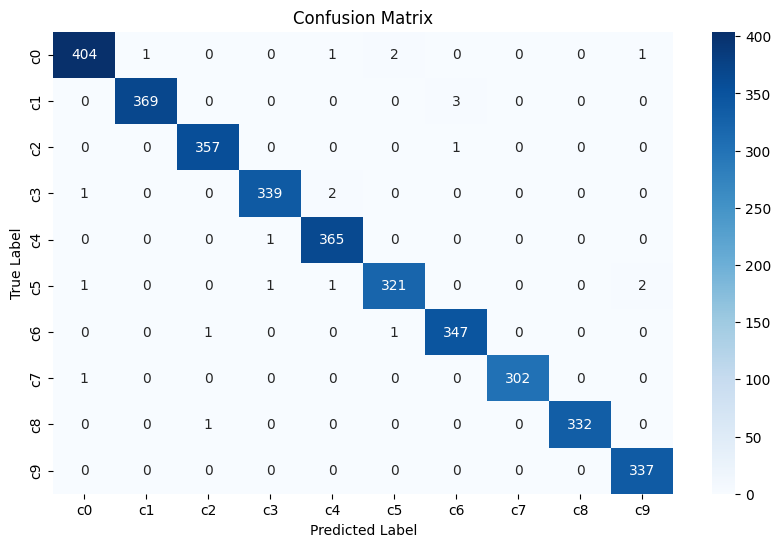

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = []
y_true = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10 , 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


훈련한 모델 저장(real_final_make_tensorflow_dataset_driver_motion.keras)

In [ ]:
import tensorflow as tf
model.save('/content/drive/MyDrive/driver_motion/real_final_make_tensorflow_dataset_driver_motion.keras')

훈련한 모델로 test 파일에 있는 이미지 한개 가져와 잘 분류하는지 확인

1/1 [==============================] - 6s 6s/step


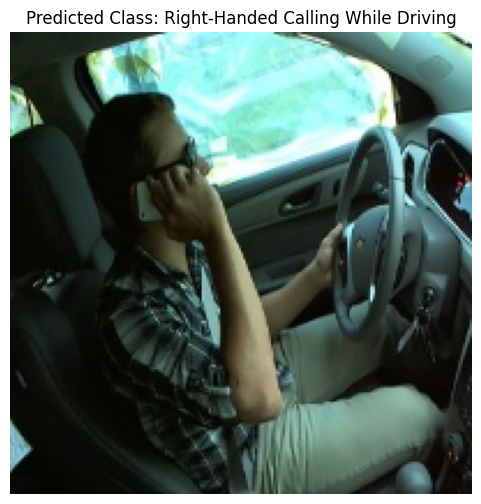

Predicted probabilities (in %): [[3.6664396e-03 4.8655056e-04 9.2209312e+01 4.7657749e-04 3.9747350e+00
  1.4292771e-01 2.2571070e+00 2.0869132e-02 1.3404717e+00 4.9947143e-02]]


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#테스트 이미지 경로
test_image_path = '/content/drive/MyDrive/driver_motion/imgs/test/img_21772.jpg'

#이미지 로드,전처리 함수 구현
def load_and_preprocess_image(image_path, target_size):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("이미지 error인것같네요")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size[:2])
    img_array = np.asarray(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

target_size = (200, 200)
test_img_array = load_and_preprocess_image(test_image_path, target_size)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

#클래스 이름 정의
class_names = {
    0: 'Safe Driving',
    1: 'Left-Handed Phone Use While Driving',
    2: 'Right-Handed Calling While Driving',
    3: 'Right-Handed Phone Use While Driving',
    4: 'Left-Handed Calling While Driving',
    5: 'Navigation Use While Driving',
    6: 'Drinking Coffee While Driving',
    7: 'Reaching to the Back While Driving',
    8: 'Grooming While Driving',
    9: 'Talking to Passenger While Driving'
}

predicted_class_name = class_names[predicted_class]

plt.figure(figsize=(6, 6))
plt.imshow(test_img_array[0].astype('uint8'))
plt.title(f'Predicted Class: {predicted_class_name}')
plt.axis('off')
plt.show()

print(f'Predicted probabilities (in %): {predictions * 100}')